In [31]:
import sys
# sys.path.append('/content/drive/MyDrive/imperial/RL/CW2')
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np

import gym
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Configuring Pytorch

from tqdm import tqdm

import json

import pickle

In [32]:
NUM_RUNS = 10

In [33]:
env = gym.make('CartPole-v1')
env.reset()

(array([ 0.03463038,  0.01777014, -0.02692946,  0.04181815], dtype=float32),
 {})

In [34]:
import optuna
from optuna.trial import TrialState

### Creating baseline study using Optuna

In [35]:
# Using optuna to create a study

def define_model(trial, lr, epsilon, epsilon_percentage, network_architecture, optimizer_type, activation_func, batch_size, replay_buffer_size, update_target_num):

  env = gym.make('CartPole-v1')
  policy_net = DQN(network_architecture, activation_func) # changed policy network archi as variable
  target_net = DQN(network_architecture, activation_func) # changed target network archi as variable
  update_target(target_net, policy_net)
  target_net.eval()

  # update number for how many episodes between to update target (should be changed)
  update_target_num = update_target_num

  epsilon_min = 0.05

  # changed optimizer and lr as a variable
  optimizer = getattr(optim, optimizer_type)(policy_net.parameters(), lr=lr)

  memory = ReplayBuffer(int(replay_buffer_size))

  for i_episode in tqdm(range(300)):
    # if (i_episode+1) % 50 == 0:
    #   print("episode ", i_episode+1, "/", 300)

    observation, info = env.reset()
    state = torch.tensor(observation).float()

    done = False
    terminated = False
    t = 0
    while not (done or terminated):

      # Select and perform an action
      action = epsilon_greedy(epsilon, policy_net, state)
      if epsilon > epsilon_min:
        epsilon = epsilon*epsilon_percentage
      else:
        epsilon = epsilon_min

      observation, reward, done, terminated, info = env.step(action)
      reward = torch.tensor([reward])
      action = torch.tensor([action])
      next_state = torch.tensor(observation).reshape(-1).float()

      memory.push([state, action, next_state, reward, torch.tensor([done])])

      # Move to the next state
      state = next_state

      # Perform one step of the optimization (on the policy network)
      if not len(memory.buffer) < batch_size:
        transitions = memory.sample(batch_size)
        state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
        # Compute loss
        mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
        # Optimize the model
        optimizer.zero_grad()
        mse_loss.backward()
        optimizer.step()

      t += 1

    # Update the target network, copying all weights and biases in DQN
    if i_episode % update_target_num == 0:
      update_target(target_net, policy_net)

    trial.report(t, step=i_episode)
    if trial.should_prune():
      raise optuna.TrialPruned()

  return t


In [36]:
def objective(trial):
  # lr = trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True)
  lr = trial.suggest_categorical("learning_rate", [0.1, 0.01, 0.001, 0.0001])
  epsilon = trial.suggest_float("epsilon", 0.1, 1.0, step=0.1)
  epsilon_percentage = trial.suggest_categorical("epsilon_percentage", [0.9, 0.99, 1.0])
  epsilon_min = 0.05

  network_architecture = trial.suggest_categorical("network_architecture",
                                                   [# 1 hidden layer up to 256 as maximum total hidden layer size
                                                   [4, 16, 2],
                                                   [4, 32, 2],
                                                   [4, 64, 2],
                                                   [4, 128, 2],
                                                   [4, 256, 2],
                                                   # 2 hidden layers with 2nd hidden layer size smaller than first to allow better convergence to 2 output size
                                                   [4, 16, 16, 2],
                                                   [4, 32, 16, 2],
                                                   [4, 64, 16, 2],
                                                   [4, 128, 16, 2],
                                                   [4, 32, 32, 2],
                                                   [4, 64, 32, 2],
                                                   [4, 128, 32, 2],
                                                   [4, 64, 64, 2],
                                                   [4, 128, 64, 2],
                                                   [4, 128, 128, 2],
                                                   # 3 hidden layers with pyramid architecture
                                                   [4, 16, 32, 16, 2],
                                                   [4, 32, 64, 32, 2],
                                                   [4, 64, 128, 64, 2]]
  )
  optimizer_type = trial.suggest_categorical("optimizer_type", ["Adam", "RMSprop", "SGD"])
  activation_func = trial.suggest_categorical("activation_func", ["sigmoid", "tanh", "relu", "leaky_relu"])  # some common activ func seen in papers
  batch_size = trial.suggest_categorical("batch_size", [1, 5, 10, 15, 20])

  replay_buffer_size = trial.suggest_categorical("replay_buffer_size", [100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000, 25000])
  update_target_num = trial.suggest_categorical("update_target_num", [1, 2, 5, 10])

  t = define_model(trial, lr, epsilon, epsilon_percentage, network_architecture, optimizer_type, activation_func, batch_size, replay_buffer_size)
  value = t

  return value


In [12]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000, timeout=6000)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-15 18:33:45,822] A new study created in memory with name: no-name-a36a6236-f2cf-4496-af25-f3a83b232465
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 16, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 32, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 64, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: 

Study statistics: 
  Number of finished trials:  1000
  Number of pruned trials:  891
  Number of complete trials:  109
Best trial:
  Value:  500.0
  Params: 
    learning_rate: 0.001
    epsilon: 0.9
    epsilon_percentage: 0.99
    network_architecture: [4, 16, 16, 2]
    optimizer_type: Adam
    activation_func: relu
    batch_size: 20
    replay_buffer_size: 10000


### Testing to see if model hyperparameter suggested is of good results

#### Average return of network_architecture = [4, 16, 16, 2]

In [41]:
results_baseline_dict = {}

runs_results_baseline = train_model(lr = 0.001,
                                    epsilon = 0.9,
                                    epsilon_percentage = 0.99,
                                    network_architecture = [4, 16, 16, 2],
                                    optimizer_type = "Adam",
                                    activation_func = "relu",
                                    batch_size = 20,
                                    replay_buffer_size = 10000,
                                    update_target_num = 1)

# Saving baseline params values to best_data.json file 
final_results_baseline = []
final_results = torch.tensor(runs_results_baseline)
means = final_results.float().mean(0)
stds = final_results.float().std(0)
final_results_baseline.append(means.tolist())
final_results_baseline.append(stds.tolist())

results_baseline_dict["runs_results_baseline"] = final_results_baseline

with open('baseline_data.json', 'w') as fp:
    json.dump(results_baseline_dict, fp) 

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

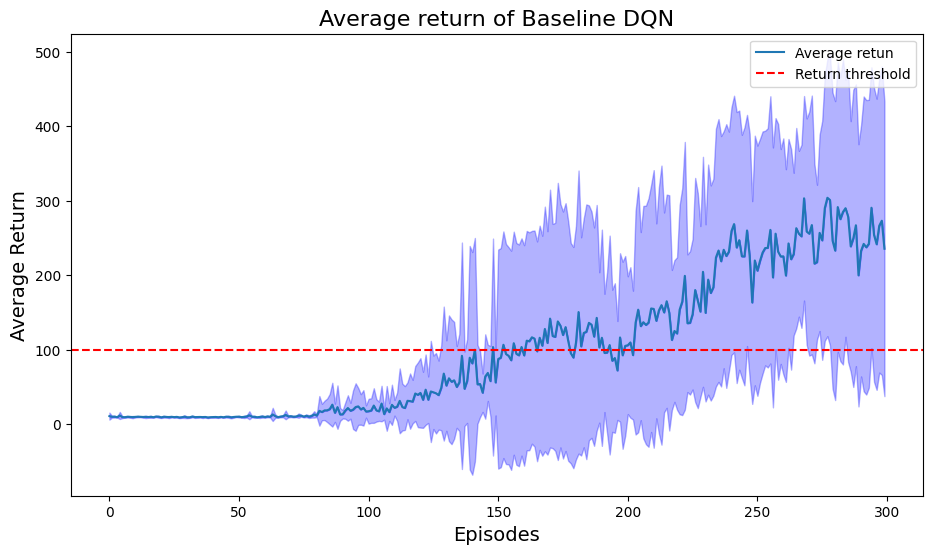

In [46]:
# Opening data to 
with open('baseline_data.json', 'r') as fp:
    data = json.load(fp) 
    
final_results_baseline = data["runs_results_baseline"] 
final_results_baseline = torch.tensor(final_results_baseline)
means = final_results_baseline[0]
stds = final_results_baseline[1]

plt.figure(figsize=(11,6))
plt.plot(torch.arange(300), means, label="Average retun")
plt.axhline(y = 100, color = 'r', linestyle = '--', label="Return threshold")
plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')


plt.ylabel("Average Return", fontsize= 14)
plt.xlabel("Episodes", fontsize= 14)
plt.title("Average return of Baseline DQN", fontsize= 16)
plt.legend()

plt.show()

In [58]:
lr = 0.001
epsilon = 0.9
epsilon_percentage = 0.99
network_architecture = [4, 16, 16, 2]
optimizer_type = "Adam"
activation_func = "relu"
batch_size = 20
replay_buffer_size = 10000
update_target_num = 1
runs_results = []
epsilon_min = 0.05

env = gym.make('CartPole-v1')
for run in range(NUM_RUNS):
  print(f"Starting run {run+1} of {NUM_RUNS}")
  policy_net = DQN(network_architecture, activation_func) # changed policy network archi as variable
  target_net = DQN(network_architecture, activation_func) # changed target network archi as variable
  update_target(target_net, policy_net)
  target_net.eval()

  # changed optimizer and lr as a variable
  optimizer = getattr(optim, optimizer_type)(policy_net.parameters(), lr=lr)

  memory = ReplayBuffer(int(replay_buffer_size))

  steps_done = 0

  episode_durations = []

  for i_episode in range(300):
    if (i_episode+1) % 50 == 0:
      print("episode ", i_episode+1, "/", 300)

    observation, info = env.reset()
    state = torch.tensor(observation).float()

    done = False
    terminated = False
    t = 0
    while not (done or terminated):

      # Select and perform an action
      action = epsilon_greedy(epsilon, policy_net, state)
      if epsilon > epsilon_min:
        epsilon = epsilon*epsilon_percentage
      else:
        epsilon = epsilon_min

      observation, reward, done, terminated, info = env.step(action)
      reward = torch.tensor([reward])
      action = torch.tensor([action])
      next_state = torch.tensor(observation).reshape(-1).float()

      memory.push([state, action, next_state, reward, torch.tensor([done])])

      # Move to the next state
      state = next_state

      # Perform one step of the optimization (on the policy network)
      if not len(memory.buffer) < batch_size:
        transitions = memory.sample(batch_size)
        state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
        # Compute loss
        mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
        # Optimize the model
        optimizer.zero_grad()
        mse_loss.backward()
        optimizer.step()

      if done or terminated:
        episode_durations.append(t + 1)
      t += 1
    # Update the target network, copying all weights and biases in DQN
    if i_episode % update_target_num == 0: # can set as variable
      update_target(target_net, policy_net)

  runs_results.append(episode_durations)

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

In [ ]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it

results = torch.tensor(runs_results)
means = results.float().mean(0)
stds = results.float().std(0)

plt.figure(figsize=(12,6))
plt.plot(torch.arange(300), means)
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.title("Average return of lr = 0.001, epsilon = 0.9, epsilon_percentage = 0.99, network_architecture = [4, 16, 16, 2], \n optimizer_type = Adam, activation_func = relu, batch_size = 20, replay_buffer_size = 10000, update_target_num = 1")

plt.show()

#### train_model for testing with episode = 50
 

In [9]:
def train_model_for_test(
  lr = 0.001,
  epsilon = 0.9,
  epsilon_percentage = 0.99,
  network_architecture = [4, 16, 16, 2],
  optimizer_type = "Adam",
  activation_func = "relu",
  batch_size = 20,
  replay_buffer_size = 10000,
  update_target_num = 1
  ):

  runs_results = []
  epsilon_min = 0.05

  env = gym.make('CartPole-v1')
  for run in range(NUM_RUNS):
    print(f"Starting run {run+1} of {NUM_RUNS}")
    policy_net = DQN(network_architecture, activation_func) # changed policy network archi as variable
    target_net = DQN(network_architecture, activation_func) # changed target network archi as variable
    update_target(target_net, policy_net)
    target_net.eval()

    # changed optimizer and lr as a variable
    optimizer = getattr(optim, optimizer_type)(policy_net.parameters(), lr=lr)

    memory = ReplayBuffer(int(replay_buffer_size))

    steps_done = 0

    episode_durations = []

    for i_episode in range(50):
      if (i_episode+1) % 50 == 0:
        print("episode ", i_episode+1, "/", 300)

      observation, info = env.reset()
      state = torch.tensor(observation).float()

      done = False
      terminated = False
      t = 0
      while not (done or terminated):

        # Select and perform an action
        action = epsilon_greedy(epsilon, policy_net, state)
        if epsilon > epsilon_min:
          epsilon = epsilon*epsilon_percentage
        else:
          epsilon = epsilon_min

        observation, reward, done, terminated, info = env.step(action)
        reward = torch.tensor([reward])
        action = torch.tensor([action])
        next_state = torch.tensor(observation).reshape(-1).float()

        memory.push([state, action, next_state, reward, torch.tensor([done])])

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        if not len(memory.buffer) < batch_size:
          transitions = memory.sample(batch_size)
          state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
          # Compute loss
          mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
          # Optimize the model
          optimizer.zero_grad()
          mse_loss.backward()
          optimizer.step()

        if done or terminated:
          episode_durations.append(t + 1)
        t += 1
      # Update the target network, copying all weights and biases in DQN
      if i_episode % update_target_num == 0: # can set as variable
        update_target(target_net, policy_net)

    runs_results.append(episode_durations)

  return runs_results


## Test and plot on baseline values

In [9]:
NUM_RUNS = 10
results_dict = {}

### trying different lr

for 0.100000 : 
Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode

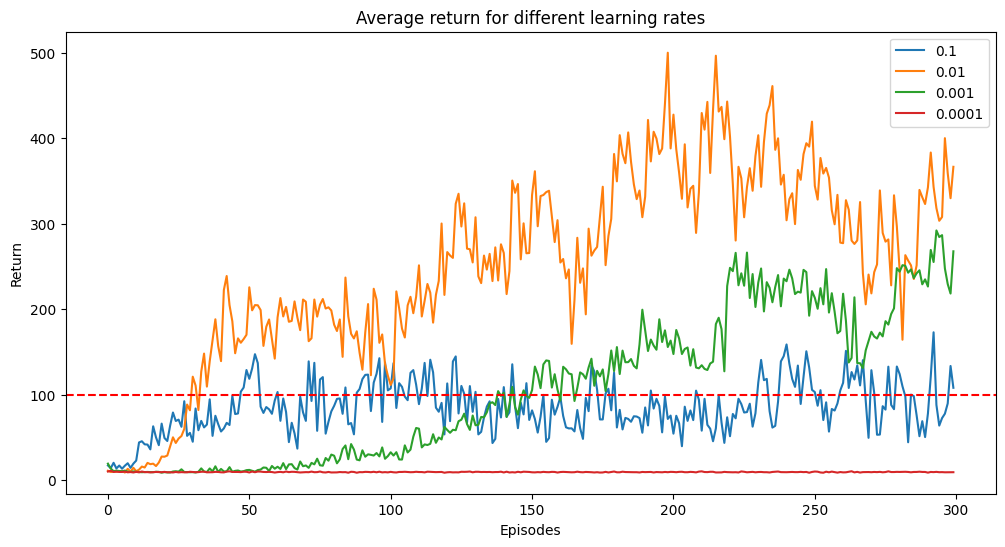

In [49]:
# running testing with specific parameter's flag to be True
final_results = hyper_param_testing(lr_flag=True)

# Plotting the learning curve
# Placeholder plot, you are free to modify it
mean_final_results = []
# std_final_results = []

for result in final_results:
  means = torch.tensor(result).float().mean(0)
  # stds = torch.tensor(result).float().std(0)
  mean_final_results.append(means)
  # std_final_results.append(stds)

new_mean_final_list = []
for i in mean_final_results:
    new_mean_final_list.append(i.tolist())
    
results_dict["lr"] = new_mean_final_list

with open('mean_data.json', 'w') as fp:
    json.dump(results_dict, fp) 
    
plt.figure(figsize=(12,6))
labels = [0.1, 0.01, 0.001, 0.0001]
for index, mean_return in enumerate(mean_final_results):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for different learning rates")

# plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
# plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.show()



### different epsilon

for 0.100000 : 
Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300


episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 9 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 10 of 10
ep

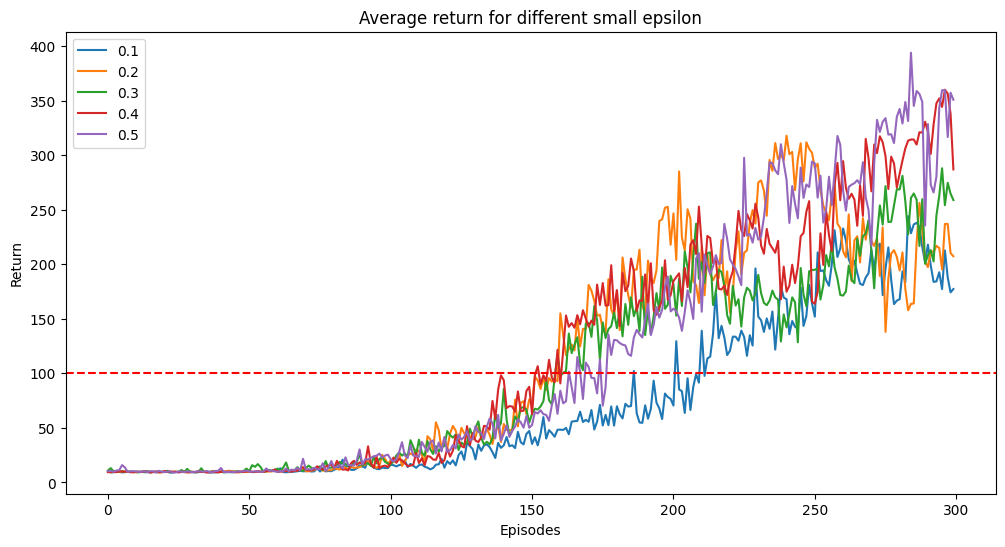

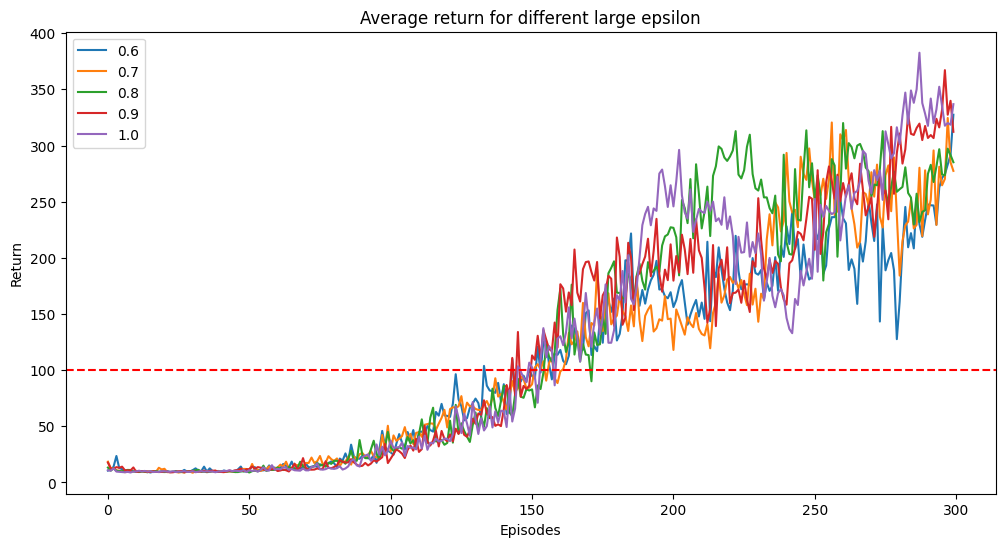

In [80]:
# running testing with specific parameter's flag to be True
final_results = hyper_param_testing(epsilon_flag=True)

# Plotting the learning curve
# Placeholder plot, you are free to modify it
mean_final_results = []
# std_final_results = []

for result in final_results:
  means = torch.tensor(result).float().mean(0)
  # stds = torch.tensor(result).float().std(0)
  mean_final_results.append(means)
  # std_final_results.append(stds)
  
new_mean_final_list = []
for i in mean_final_results:
    new_mean_final_list.append(i.tolist())
    
results_dict["epsilon"] = new_mean_final_list

with open('mean_data.json', 'w') as fp:
    json.dump(results_dict, fp) 
    
plt.figure(figsize=(12,6))
labels = [0.1, 0.2, 0.3, 0.4, 0.5]
for index, mean_return in enumerate(mean_final_results[0:5]):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for different small epsilon")
plt.show()

plt.figure(figsize=(12,6))
labels = [0.6, 0.7, 0.8, 0.9, 1.0]
for index, mean_return in enumerate(mean_final_results[5:10]):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for different large epsilon")

# plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
# plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.show()



### different epsilon_percentage

for 0.900000 : 
Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode

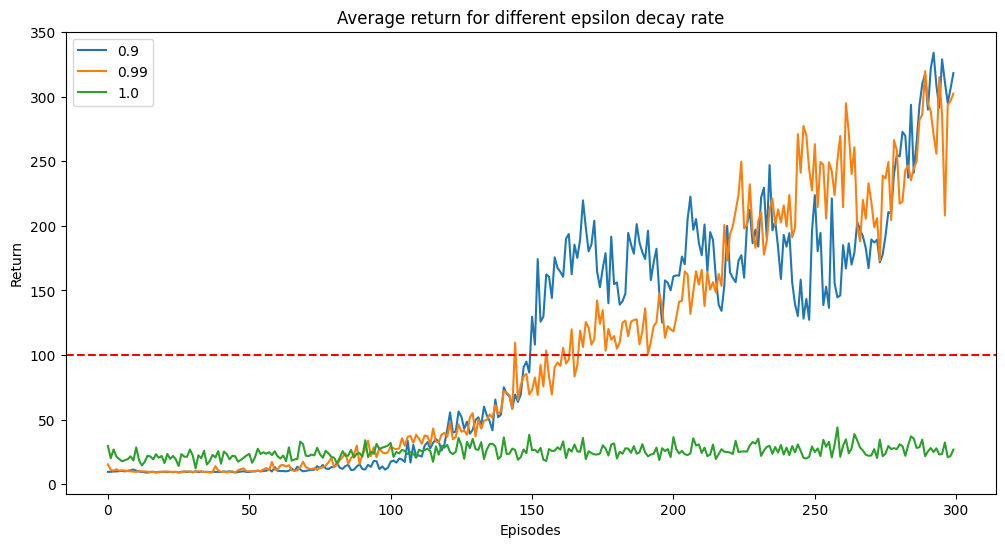

In [81]:
# running testing with specific parameter's flag to be True
final_results = hyper_param_testing(epsilon_percentage_flag=True)

# Plotting the learning curve
# Placeholder plot, you are free to modify it
mean_final_results = []
# std_final_results = []

for result in final_results:
  means = torch.tensor(result).float().mean(0)
  # stds = torch.tensor(result).float().std(0)
  mean_final_results.append(means)
  # std_final_results.append(stds)
  
new_mean_final_list = []
for i in mean_final_results:
    new_mean_final_list.append(i.tolist())
    
results_dict["epsilon_percentage"] = new_mean_final_list

with open('mean_data.json', 'w') as fp:
    json.dump(results_dict, fp) 
    
plt.figure(figsize=(12,6))
labels = [0.9, 0.99, 1.0]
for index, mean_return in enumerate(mean_final_results):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for different epsilon decay rate")

# plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
# plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.show()



### different network_architecture

for [4, 16, 2] : 
Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episo

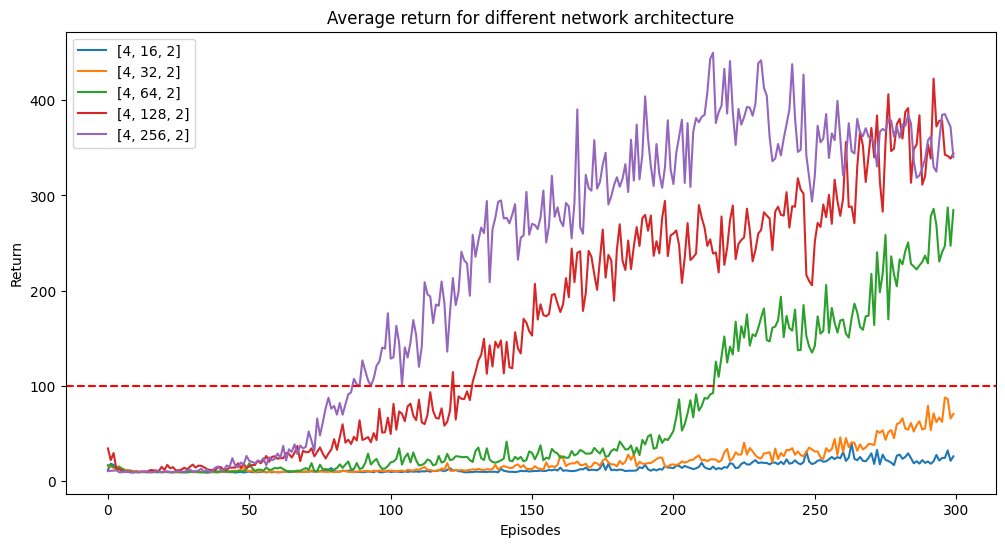

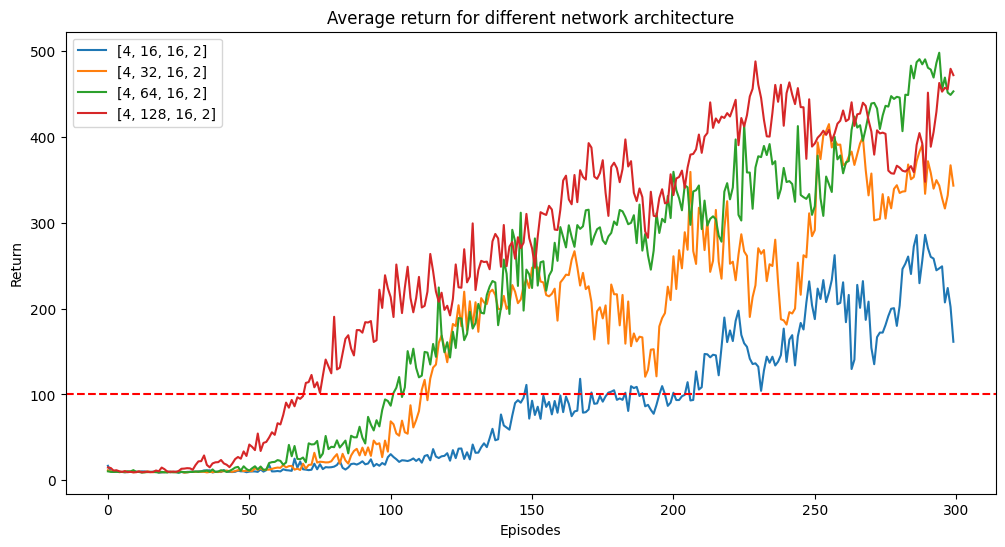

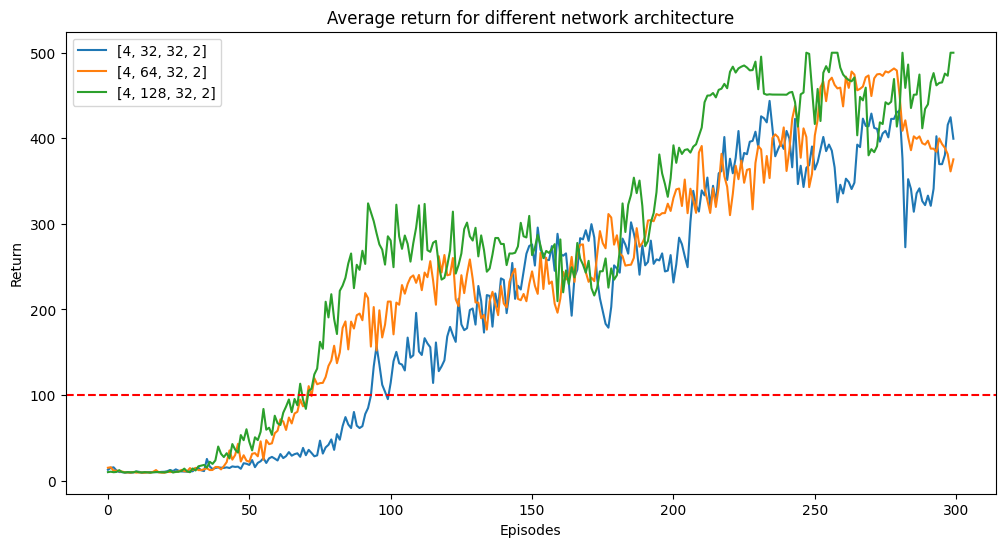

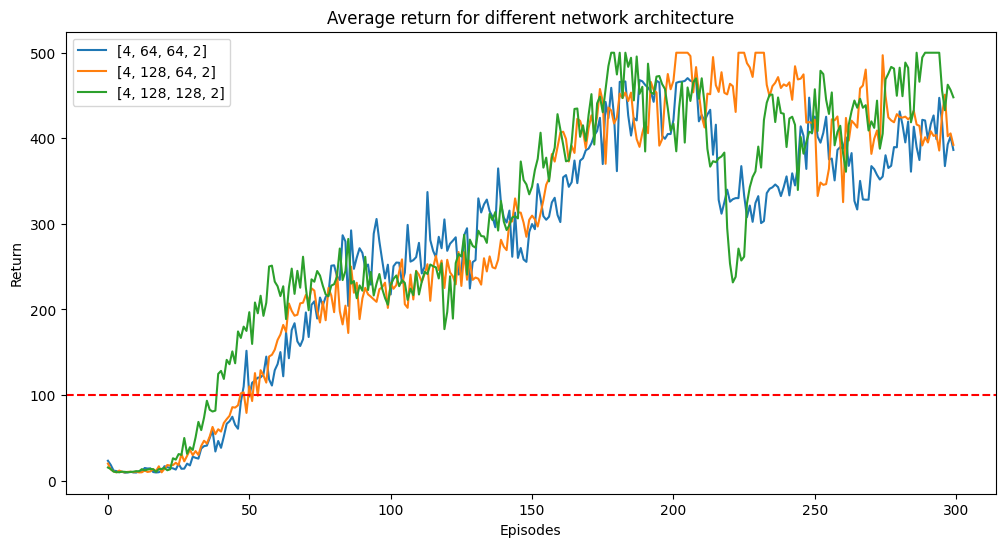

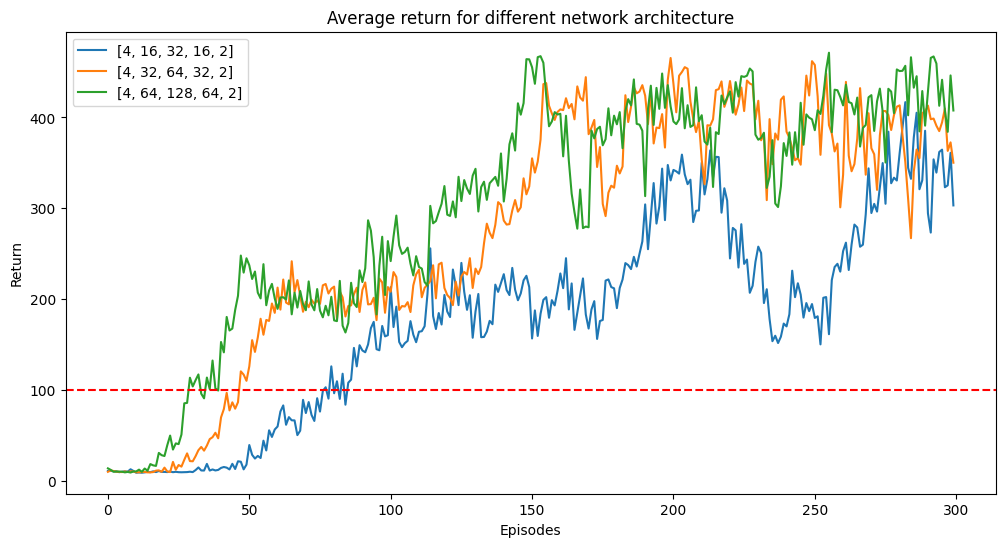

In [10]:
# running testing with specific parameter's flag to be True
final_results = hyper_param_testing(network_architecture_flag=True)

# Plotting the learning curve
# Placeholder plot, you are free to modify it
mean_final_results = []
# std_final_results = []

for result in final_results:
  means = torch.tensor(result).float().mean(0)
  # stds = torch.tensor(result).float().std(0)
  mean_final_results.append(means)
  # std_final_results.append(stds)

new_mean_final_list = []
for i in mean_final_results:
    new_mean_final_list.append(i.tolist())
    
results_dict["network_architecture"] = new_mean_final_list

with open('mean_data.json', 'w') as fp:
    json.dump(results_dict, fp) 
    
plt.figure(figsize=(12,6))
labels = [# 1 hidden layer up to 256 as maximum total hidden layer size
          [4, 16, 2],
          [4, 32, 2],
          [4, 64, 2],
          [4, 128, 2],
          [4, 256, 2]]
for index, mean_return in enumerate(mean_final_results[0:5]):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for different network architecture")
plt.show()

plt.figure(figsize=(12,6))
labels = [ # 2 hidden layers with 2nd hidden layer size smaller than first to allow better convergence to 2 output size
          [4, 16, 16, 2],
          [4, 32, 16, 2],
          [4, 64, 16, 2],
          [4, 128, 16, 2]]
for index, mean_return in enumerate(mean_final_results[5:9]):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for different network architecture")
plt.show()

plt.figure(figsize=(12,6))
labels = [[4, 32, 32, 2],
          [4, 64, 32, 2],
          [4, 128, 32, 2]]
for index, mean_return in enumerate(mean_final_results[9:12]):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for different network architecture")
plt.show()

plt.figure(figsize=(12,6))
labels = [[4, 64, 64, 2],
          [4, 128, 64, 2],
          [4, 128, 128, 2]]
for index, mean_return in enumerate(mean_final_results[12:15]):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for different network architecture")
plt.show()

plt.figure(figsize=(12,6))
labels = [# 3 hidden layers with pyramid architecture
          [4, 16, 32, 16, 2],
          [4, 32, 64, 32, 2],
          [4, 64, 128, 64, 2]]
for index, mean_return in enumerate(mean_final_results[15:18]):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for different network architecture")
plt.show()

# plt.figure(figsize=(12,6))
# labels = [# 1 hidden layer up to 256 as maximum total hidden layer size
#           [4, 16, 2],
#           [4, 32, 2],
#           [4, 64, 2],
#           [4, 128, 2],
#           [4, 256, 2],
#           # 2 hidden layers with 2nd hidden layer size smaller than first to allow better convergence to 2 output size
#           [4, 16, 16, 2],
#           [4, 32, 16, 2],
#           [4, 64, 16, 2],
#           [4, 128, 16, 2],
#           [4, 32, 32, 2],
#           [4, 64, 32, 2],
#           [4, 128, 32, 2],
#           [4, 64, 64, 2],
#           [4, 128, 64, 2],
#           [4, 128, 128, 2],
#           # 3 hidden layers with pyramid architecture
#           [4, 16, 32, 16, 2],
#           [4, 32, 64, 32, 2],
#           [4, 64, 128, 64, 2]]
# for index, mean_return in enumerate(mean_final_results):
#   plt.plot(torch.arange(300), mean_return, label = labels[index])
# plt.axhline(y = 100, color = 'r', linestyle = '--')
# plt.ylabel("Return")
# plt.xlabel("Episodes")
# plt.legend()
# plt.title("Average return for different network architecture")
# plt.show()

### different optimizer_type

In [47]:
results_dict = {}

for Adam : 
Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  10

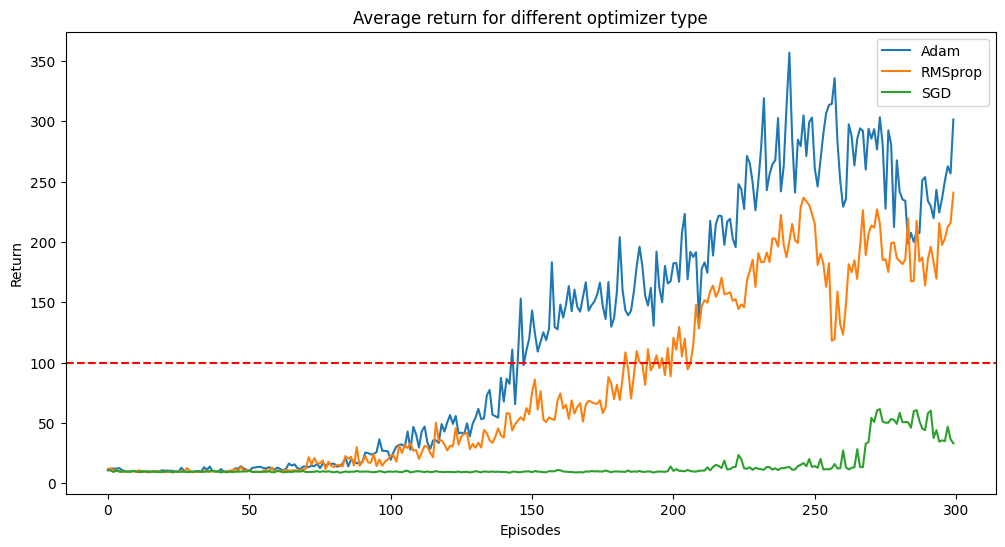

In [48]:
# running testing with specific parameter's flag to be True
final_results = hyper_param_testing(optimizer_type_flag=True)

# Plotting the learning curve
# Placeholder plot, you are free to modify it
mean_final_results = []
# std_final_results = []

for result in final_results:
  means = torch.tensor(result).float().mean(0)
  # stds = torch.tensor(result).float().std(0)
  mean_final_results.append(means)
  # std_final_results.append(stds)

new_mean_final_list = []
for i in mean_final_results:
    new_mean_final_list.append(i.tolist())
    
results_dict["optimizer_type"] = new_mean_final_list

with open('mean_data.json', 'w') as fp:
    json.dump(results_dict, fp) 
    
plt.figure(figsize=(12,6))
labels = ["Adam", "RMSprop", "SGD"]
for index, mean_return in enumerate(mean_final_results):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for different optimizer type")

# plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
# plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.show()



### different activation_func

for sigmoid : 
Starting run 1 of 10


/home/qtlim/anaconda3/envs/rl_cw2/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episod

episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 10 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
for tanh : 
Starting run 1 of 10


/home/qtlim/anaconda3/envs/rl_cw2/lib/python3.8/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episod

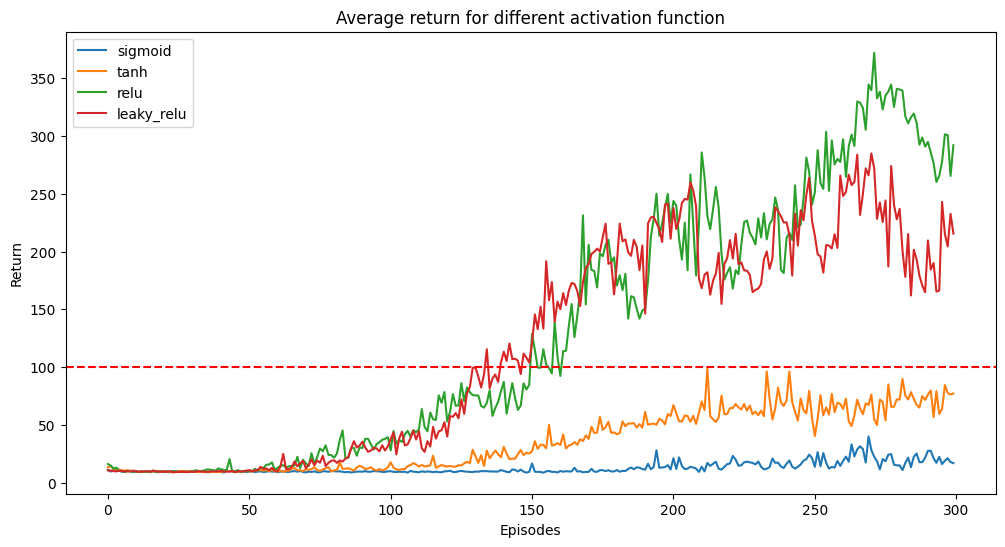

In [12]:
# running testing with specific parameter's flag to be True
final_results = hyper_param_testing(activation_func_flag=True)

# Plotting the learning curve
# Placeholder plot, you are free to modify it
mean_final_results = []
# std_final_results = []

for result in final_results:
  means = torch.tensor(result).float().mean(0)
  # stds = torch.tensor(result).float().std(0)
  mean_final_results.append(means)
  # std_final_results.append(stds)

new_mean_final_list = []
for i in mean_final_results:
    new_mean_final_list.append(i.tolist())
    
results_dict["activation_func"] = new_mean_final_list

with open('mean_data.json', 'w') as fp:
    json.dump(results_dict, fp) 
    
plt.figure(figsize=(12,6))
labels = ["sigmoid", "tanh", "relu", "leaky_relu"]
for index, mean_return in enumerate(mean_final_results):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for different activation function")

# plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
# plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.show()



### different batch_size

for 1.000000 : 
Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300


episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 9 of 10
episode  50 / 300
epis

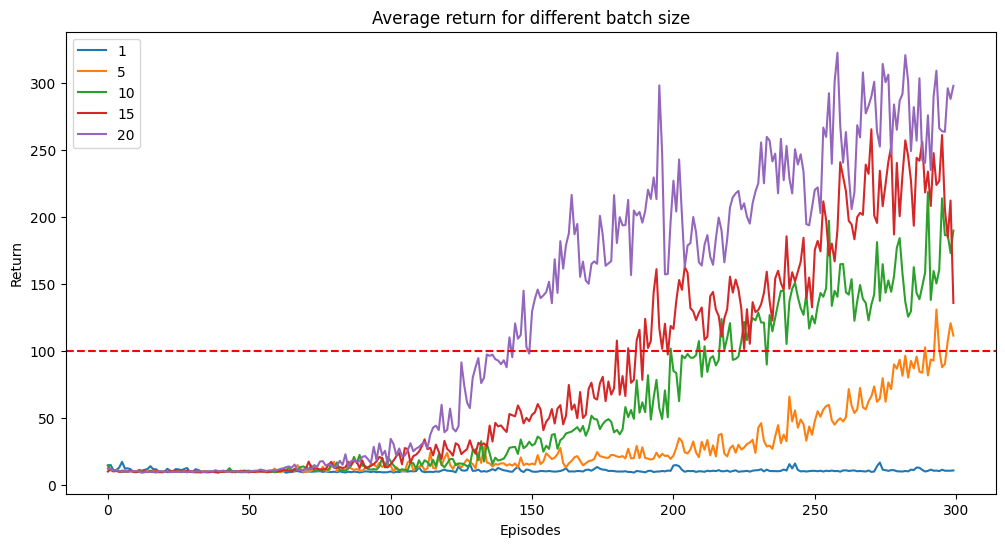

In [13]:
# running testing with specific parameter's flag to be True
final_results = hyper_param_testing(batch_size_flag=True)

# Plotting the learning curve
# Placeholder plot, you are free to modify it
mean_final_results = []
# std_final_results = []

for result in final_results:
  means = torch.tensor(result).float().mean(0)
  # stds = torch.tensor(result).float().std(0)
  mean_final_results.append(means)
  # std_final_results.append(stds)

new_mean_final_list = []
for i in mean_final_results:
    new_mean_final_list.append(i.tolist())
    
results_dict["batch_size"] = new_mean_final_list

with open('mean_data.json', 'w') as fp:
    json.dump(results_dict, fp) 
    
plt.figure(figsize=(12,6))
labels = [1, 5, 10, 15, 20]
for index, mean_return in enumerate(mean_final_results):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for different batch size")

# plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
# plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.show()



### different replay_buffer_size

In [ ]:
# running testing with specific parameter's flag to be True
final_results = hyper_param_testing(replay_buffer_size_flag=True)

for 100.000000 : 
Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300


episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 9 of 10
episode  50 / 300
epis

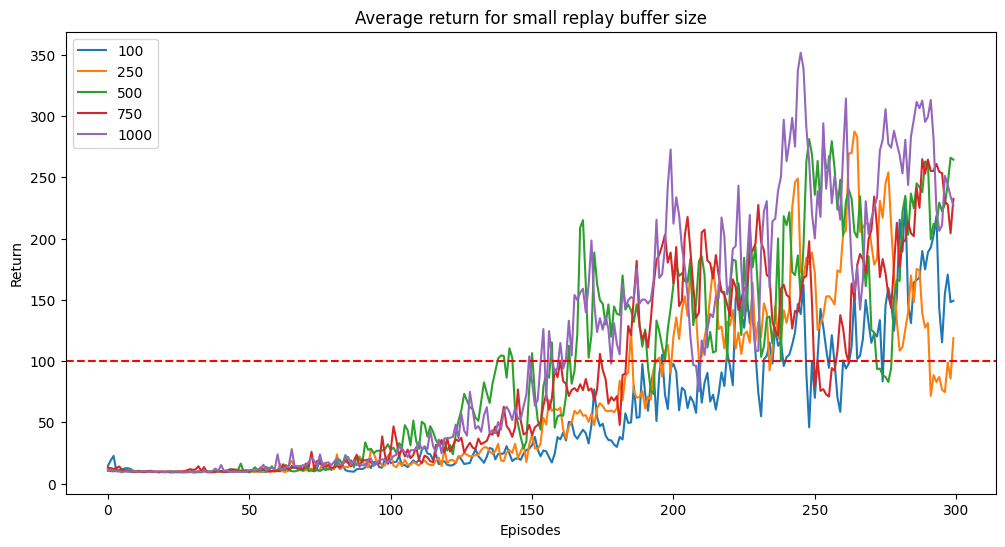

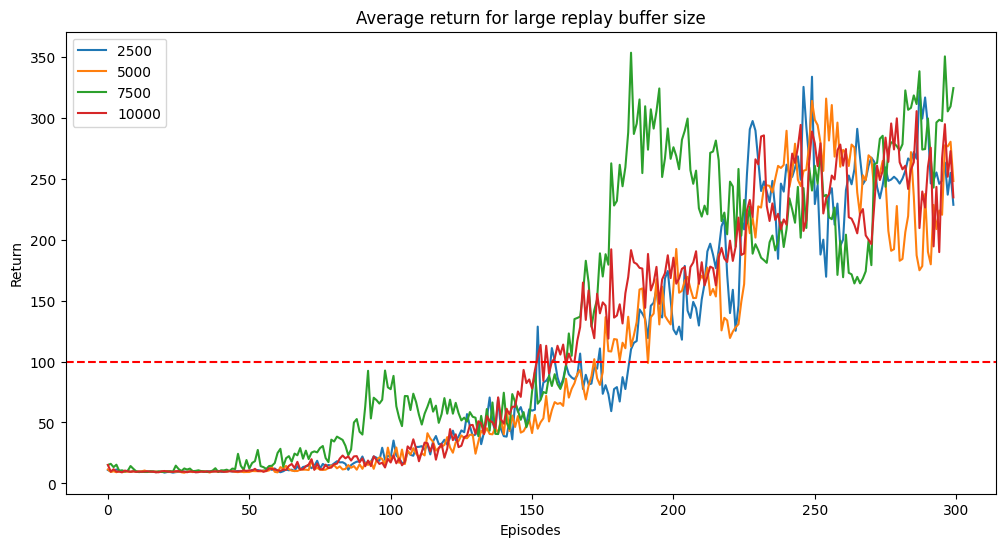

In [14]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it
mean_final_results = []
# std_final_results = []

for result in final_results:
  means = torch.tensor(result).float().mean(0)
  # stds = torch.tensor(result).float().std(0)
  mean_final_results.append(means)
  # std_final_results.append(stds)

new_mean_final_list = []
for i in mean_final_results:
    new_mean_final_list.append(i.tolist())
    
results_dict["replay_buffer_size"] = new_mean_final_list

with open('mean_data.json', 'w') as fp:
    json.dump(results_dict, fp) 
    
plt.figure(figsize=(12,6))
labels = [100, 250, 500, 750, 1000]
for index, mean_return in enumerate(mean_final_results[0:5]):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for small replay buffer size")
plt.show()

plt.figure(figsize=(12,6))
labels = [2500, 5000, 7500, 10000, 25000]
for index, mean_return in enumerate(mean_final_results[5:10]):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for large replay buffer size")
plt.show()



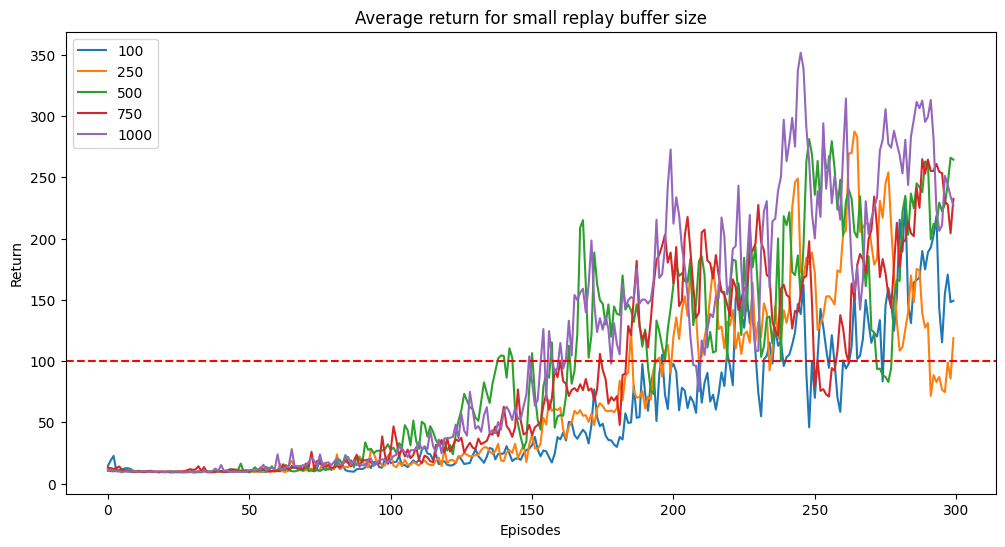

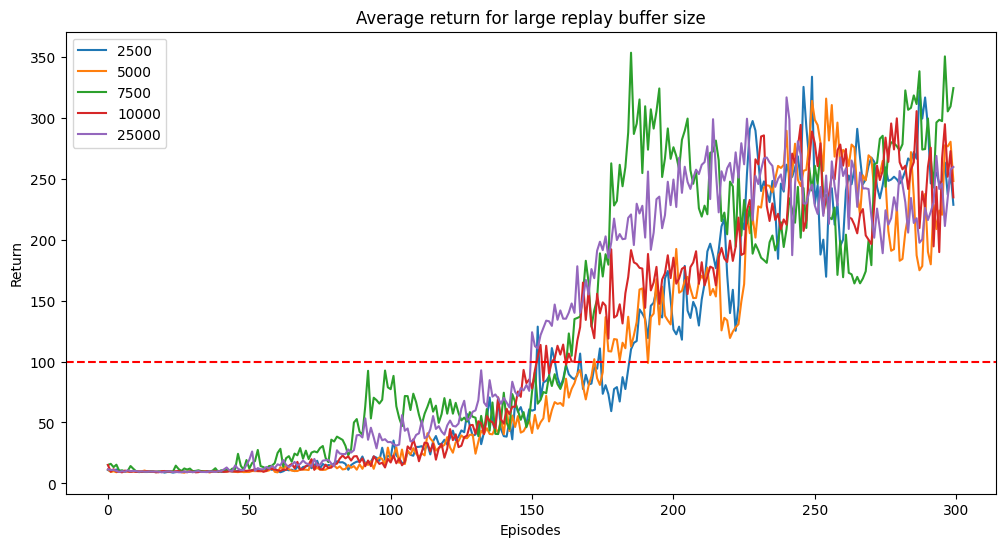

In [17]:
# Plotting the learning curve
with open('mean_data.json', 'r') as fp:
    data = json.load(fp)  
    
mean_final_results = data["replay_buffer_size"]
plt.figure(figsize=(12,6))
labels = [100, 250, 500, 750, 1000]
for index, mean_return in enumerate(mean_final_results[0:5]):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for small replay buffer size")
plt.show()

plt.figure(figsize=(12,6))
labels = [2500, 5000, 7500, 10000, 25000]
for index, mean_return in enumerate(mean_final_results[5:10]):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for large replay buffer size")
plt.show()



### different update_target_num

for 1.000000 : 
Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode

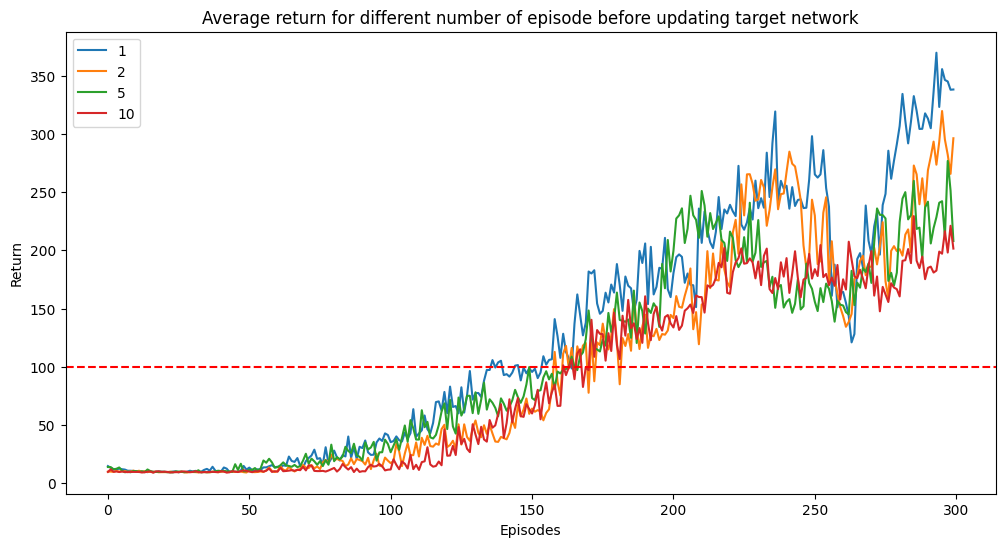

In [15]:
# running testing with specific parameter's flag to be True
final_results = hyper_param_testing(update_target_num_flag=True)

# Plotting the learning curve
# Placeholder plot, you are free to modify it
mean_final_results = []
# std_final_results = []

for result in final_results:
  means = torch.tensor(result).float().mean(0)
  # stds = torch.tensor(result).float().std(0)
  mean_final_results.append(means)
  # std_final_results.append(stds)

new_mean_final_list = []
for i in mean_final_results:
    new_mean_final_list.append(i.tolist())
    
results_dict["update_target_num"] = new_mean_final_list

with open('mean_data.json', 'w') as fp:
    json.dump(results_dict, fp) 
    
plt.figure(figsize=(12,6))
labels = [1, 2, 5, 10]
for index, mean_return in enumerate(mean_final_results):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for different number of episode before updating target network")

# plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
# plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.show()



### Plot with best hyperparameters

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

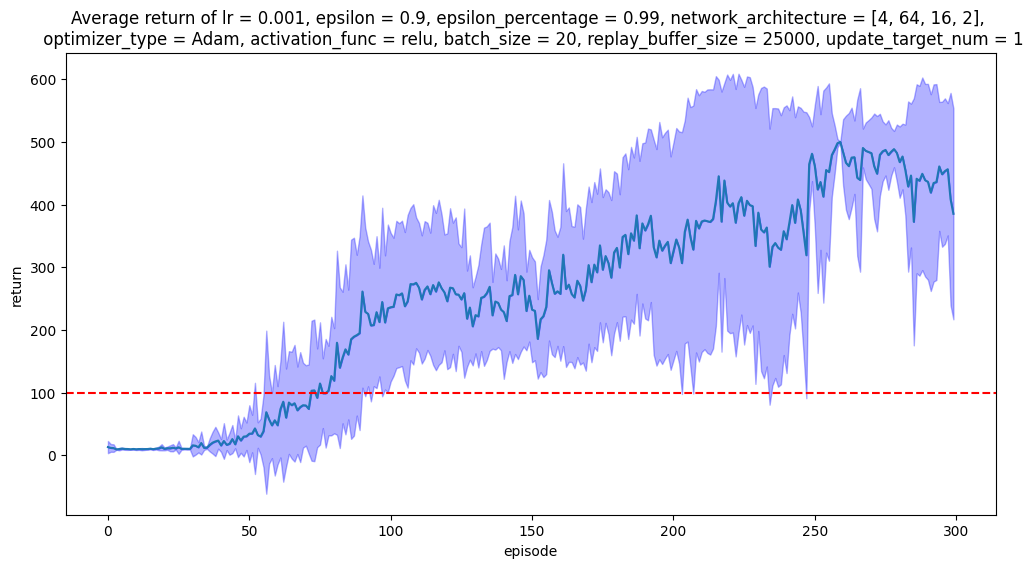

In [28]:
# Plotting the learning curve for best Hyperparameters derived from graph results 

runs_results = train_model(lr = 0.001, 
                           epsilon = 0.9,
                           epsilon_percentage = 0.99,
                           network_architecture = [4, 64, 32, 2],
                           optimizer_type = "Adam",
                           activation_func = "relu",
                           batch_size = 20,
                           replay_buffer_size = 10000,
                           update_target_num = 1)

results = torch.tensor(runs_results)
means = results.float().mean(0)
stds = results.float().std(0)

plt.figure(figsize=(12,6))
plt.plot(torch.arange(300), means)
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.title("Average return of Tuned DQN")

plt.show()

In [50]:
best_results_dict = {}

In [ ]:
# Plotting the learning curve for best Hyperparameters derived from graph results 

tuned_runs_results = get_results_and_dqn_policy_net(lr = 0.01, 
                           epsilon = 0.9,
                           epsilon_percentage = 0.99,
                           network_architecture = [4, 128, 128, 2],
                           optimizer_type = "Adam",
                           activation_func = "relu",
                           batch_size = 20,
                           replay_buffer_size = 10000,
                           update_target_num = 1)

results = torch.tensor(runs_results)
means = results.float().mean(0)
stds = results.float().std(0)

# Saving best params values to best_data.json file 
final_results_mean_and_std = []
final_results = torch.tensor(runs_results)
means = final_results.float().mean(0)
stds = final_results.float().std(0)
final_results_mean_and_std.append(means.tolist())
final_results_mean_and_std.append(stds.tolist())

best_results_dict["best_hyperparams_plot"] = final_results_mean_and_std

with open('best_data.json', 'w') as fp:
    json.dump(best_results_dict, fp) 

In [ ]:
with open('best_data.json', 'r') as fp:
    data = json.load(fp) 

final_results_mean_and_std = data["best_hyperparams_plot"] 
final_results_mean_and_std = torch.tensor(final_results_mean_and_std)
means = final_results_mean_and_std[0]
stds = final_results_mean_and_std[1]

plt.figure(figsize=(12,6))
plt.plot(torch.arange(300), means)
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.title("Average return of final hyperparameters", fontsize=14)

plt.show()

plt.figure(figsize=(12,6))
plt.plot(torch.arange(300), means)
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.title("Average return of Tuned DQN")

plt.show()

In [29]:
best_results_dict = {}

In [31]:
# Saving best params values to best_data.json file 
final_results_mean_and_std = []
final_results = torch.tensor(runs_results)
means = final_results.float().mean(0)
stds = final_results.float().std(0)
final_results_mean_and_std.append(means.tolist())
final_results_mean_and_std.append(stds.tolist())

best_results_dict["best_hyperparams_plot"] = final_results_mean_and_std

with open('best_data.json', 'w') as fp:
    json.dump(best_results_dict, fp) 

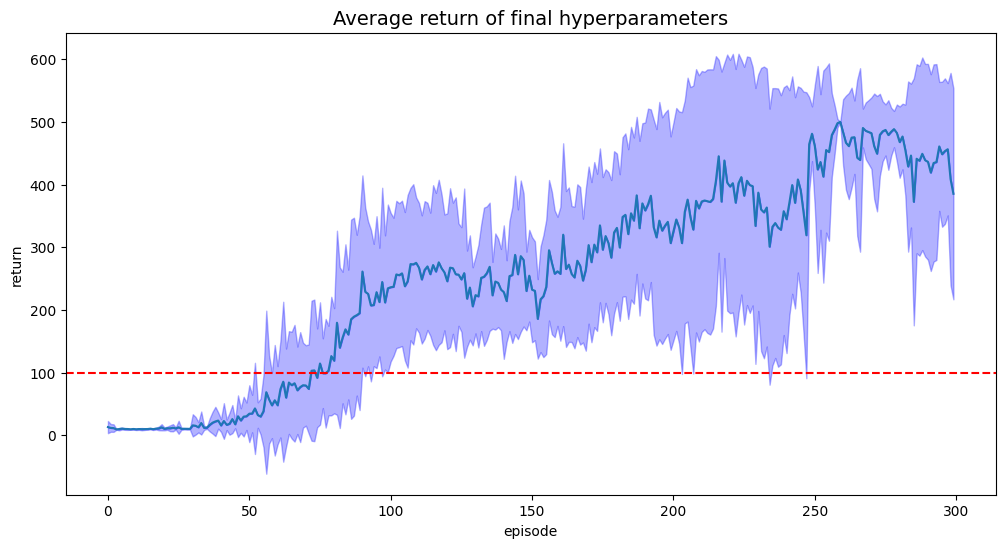

In [45]:
with open('best_data.json', 'r') as fp:
    data = json.load(fp) 

final_results_mean_and_std = data["best_hyperparams_plot"] 
final_results_mean_and_std = torch.tensor(final_results_mean_and_std)
means = final_results_mean_and_std[0]
stds = final_results_mean_and_std[1]

plt.figure(figsize=(12,6))
plt.plot(torch.arange(300), means)
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.title("Average return of final hyperparameters", fontsize=14)

plt.show()

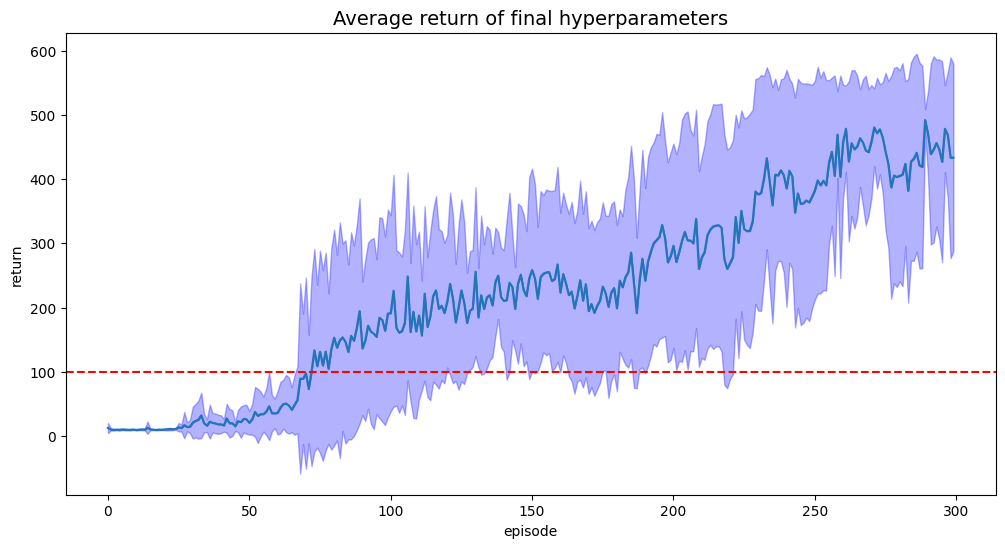

In [108]:
with open('best_model_testing_RMS.json', 'r') as fp:
    data = json.load(fp) 
    
final_results_mean_and_std = data["result_tuned_RMSprop"] 
final_results_mean_and_std = torch.tensor(final_results_mean_and_std)
means = final_results_mean_and_std[0]
stds = final_results_mean_and_std[1]

plt.figure(figsize=(12,6))
plt.plot(torch.arange(300), means)
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.title("Average return of final hyperparameters", fontsize=14)

plt.show()

for rms prop and lr = 0.01

In [ ]:
# Plotting the learning curve for best Hyperparameters derived from graph results 

runs_results_RMS = train_model(lr = 0.01, 
                           epsilon = 0.9,
                           epsilon_percentage = 0.99,
                           network_architecture = [4, 64, 32, 2],
                           optimizer_type = "Adam",
                           activation_func = "relu",
                           batch_size = 20,
                           replay_buffer_size = 10000,
                           update_target_num = 1)

results = torch.tensor(runs_results)
means = results.float().mean(0)
stds = results.float().std(0)

plt.figure(figsize=(12,6))
plt.plot(torch.arange(300), means)
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.title("Average return of Tuned DQN")

plt.show()

### Testing on effect of $\epsilon$ decay and no $\epsilon$ decay with best model

In [46]:
best_model_testing_dict = {}

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

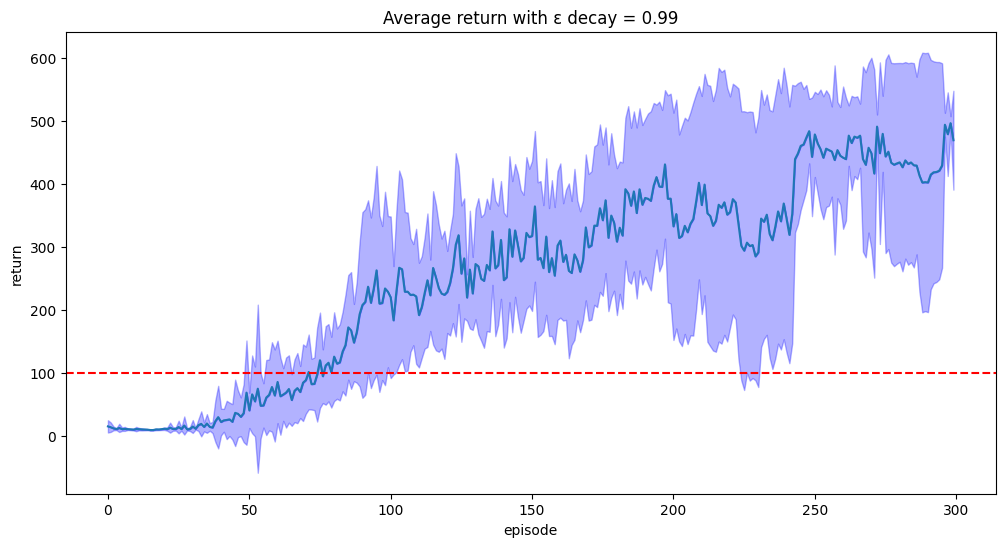

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

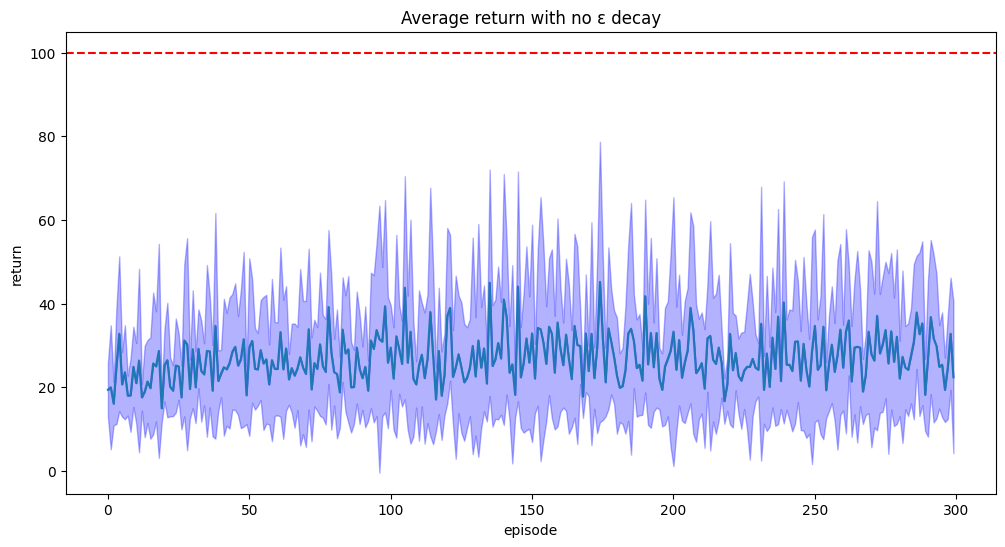

In [54]:
runs_results_with_decay = train_model(lr = 0.001, 
                           epsilon = 0.9,
                           epsilon_percentage = 0.99,
                           network_architecture = [4, 64, 32, 2],
                           optimizer_type = "Adam",
                           activation_func = "relu",
                           batch_size = 20,
                           replay_buffer_size = 10000,
                           update_target_num = 1)

result_testing_decay_mean_and_std = []
final_results = torch.tensor(runs_results_with_decay)
means = final_results.float().mean(0)
stds = final_results.float().std(0)
result_testing_decay_mean_and_std.append(means.tolist())
result_testing_decay_mean_and_std.append(stds.tolist())

best_model_testing_dict["testing_with_decay"] = result_testing_decay_mean_and_std

with open('best_model_testing.json', 'w') as fp:
    json.dump(best_model_testing_dict, fp) 

# # to read out if needed
# with open('best_model_testing.json', 'r') as fp:
#     data = json.load(fp) 

# final_results_mean_and_std = data["testing_with_decay"] 
# result_testing_decay_mean_and_std = torch.tensor(result_testing_decay_mean_and_std)
# means = result_testing_decay_mean_and_std[0]
# stds = result_testing_decay_mean_and_std[1]

plt.figure(figsize=(12,6))
plt.plot(torch.arange(300), means)
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.title("Average return with ε decay = 0.99")
plt.show()

runs_results_no_decay = train_model(lr = 0.001, 
                           epsilon = 0.9,
                           epsilon_percentage = 1.0,
                           network_architecture = [4, 64, 32, 2],
                           optimizer_type = "Adam",
                           activation_func = "relu",
                           batch_size = 20,
                           replay_buffer_size = 10000,
                           update_target_num = 1)

result_testing_decay_mean_and_std = []
final_results = torch.tensor(runs_results_no_decay)
means = final_results.float().mean(0)
stds = final_results.float().std(0)
result_testing_decay_mean_and_std.append(means.tolist())
result_testing_decay_mean_and_std.append(stds.tolist())

best_model_testing_dict["testing_no_decay"] = result_testing_decay_mean_and_std

with open('best_model_testing.json', 'w') as fp:
    json.dump(best_model_testing_dict, fp) 

# # to read out if needed
# with open('best_model_testing.json', 'r') as fp:
#     data = json.load(fp) 

# final_results_mean_and_std = data["testing_no_decay"] 
# result_testing_decay_mean_and_std = torch.tensor(result_testing_decay_mean_and_std)
# means = result_testing_decay_mean_and_std[0]
# stds = result_testing_decay_mean_and_std[1]

plt.figure(figsize=(12,6))
plt.plot(torch.arange(300), means)
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.title("Average return with no ε decay")

plt.show()

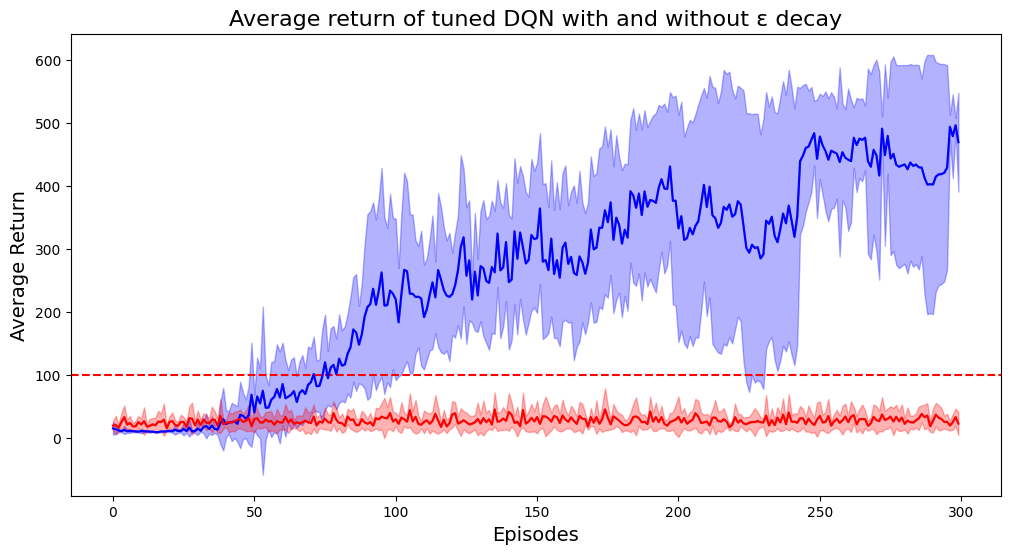

In [20]:
# # to read out if needed
with open('best_model_testing_decay_no_decay.json', 'r') as fp:
    data = json.load(fp) 
    
final_results_decay = data["testing_with_decay"] 
result_testing_decay_mean_and_std = torch.tensor(final_results_decay)
means_decay = result_testing_decay_mean_and_std[0]
stds_decay = result_testing_decay_mean_and_std[1]

final_results_no_decay = data["testing_no_decay"] 
result_testing_no_decay_mean_and_std = torch.tensor(final_results_no_decay)
means_no_decay = result_testing_no_decay_mean_and_std[0]
stds_no_decay = result_testing_no_decay_mean_and_std[1]

plt.figure(figsize=(12,6))
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.plot(torch.arange(300), means_decay, color='b')
plt.fill_between(np.arange(300), means_decay, means_decay+stds_decay, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means_decay, means_decay-stds_decay, alpha=0.3, color='b')

plt.plot(torch.arange(300), means_no_decay, color='r')
plt.fill_between(np.arange(300), means_no_decay, means_no_decay+stds_no_decay, alpha=0.3, color='r')
plt.fill_between(np.arange(300), means_no_decay, means_no_decay-stds_no_decay, alpha=0.3, color='r')

plt.ylabel("Average Return", fontsize= 14)
plt.xlabel("Episodes", fontsize= 14)
plt.title("Average return of tuned DQN with and without ε decay", fontsize= 16)

plt.show()

In [11]:
def get_results_and_dqn_policy_net(
  lr = 0.001, 
  epsilon = 0.9,
  epsilon_percentage = 0.99,
  network_architecture = [4, 64, 32, 2],
  optimizer_type = "Adam",
  activation_func = "relu",
  batch_size = 20,
  replay_buffer_size = 10000,
  update_target_num = 1
  ):

  runs_results = []
  epsilon_min = 0.05

  env = gym.make('CartPole-v1')
  for run in range(NUM_RUNS):
    print(f"Starting run {run+1} of {NUM_RUNS}")
    policy_net = DQN(network_architecture, activation_func) # changed policy network archi as variable
    target_net = DQN(network_architecture, activation_func) # changed target network archi as variable
    update_target(target_net, policy_net)
    target_net.eval()

    # changed optimizer and lr as a variable
    optimizer = getattr(optim, optimizer_type)(policy_net.parameters(), lr=lr)

    memory = ReplayBuffer(int(replay_buffer_size))

    steps_done = 0

    episode_durations = []

    for i_episode in range(300):
      if (i_episode+1) % 50 == 0:
        print("episode ", i_episode+1, "/", 300)

      observation, info = env.reset()
      state = torch.tensor(observation).float()

      done = False
      terminated = False
      t = 0
      while not (done or terminated):

        # Select and perform an action
        action = epsilon_greedy(epsilon, policy_net, state)
        if epsilon > epsilon_min:
          epsilon = epsilon*epsilon_percentage
        else:
          epsilon = epsilon_min

        observation, reward, done, terminated, info = env.step(action)
        reward = torch.tensor([reward])
        action = torch.tensor([action])
        next_state = torch.tensor(observation).reshape(-1).float()

        memory.push([state, action, next_state, reward, torch.tensor([done])])

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        if not len(memory.buffer) < batch_size:
          transitions = memory.sample(batch_size)
          state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
          # Compute loss
          mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
          # Optimize the model
          optimizer.zero_grad()
          mse_loss.backward()
          optimizer.step()

        if done or terminated:
          episode_durations.append(t + 1)
        t += 1
      # Update the target network, copying all weights and biases in DQN
      if i_episode % update_target_num == 0: # can set as variable
        update_target(target_net, policy_net)

    runs_results.append(episode_durations)

  return policy_net, runs_results


### Using best hyperparameter values to train tuned DQN

In [52]:
tuned_DQN_results_dict = {}

In [53]:
# Plotting the learning curve for best Hyperparameters derived from graph results 

policy_net_tuned, runs_results_tuned = get_results_and_dqn_policy_net(lr = 0.01, 
                                                          epsilon = 0.9,
                                                          epsilon_percentage = 0.99,
                                                          network_architecture = [4, 128, 128, 2],
                                                          optimizer_type = "Adam",
                                                          activation_func = "relu",
                                                          batch_size = 20,
                                                          replay_buffer_size = 10000,
                                                          update_target_num = 1)

result_tuned = []
final_results = torch.tensor(runs_results_tuned)
means = final_results.float().mean(0)
stds = final_results.float().std(0)
result_tuned.append(means.tolist())
result_tuned.append(stds.tolist())

tuned_DQN_results_dict["results_DQN_tuned"] = result_tuned

# saving tuned_results into json
with open('tuned_DQN.json', 'w') as fp:
    json.dump(tuned_DQN_results_dict, fp) 

# Saving tuned model into pickel object
with open("tuned_DQN.pkl", 'wb') as file:  
    pickle.dump(policy_net_tuned, file)
    

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

### getting untuned DQN data

In [54]:
result_untuned_dict = {}

In [ ]:
runs_results_untuned = train_model(lr = 1., 
                           epsilon = 1.,
                           epsilon_percentage = 1.,
                           network_architecture = [4, 2],
                           optimizer_type = "SGD",
                           activation_func = "relu",
                           batch_size = 1,
                           replay_buffer_size = 1,
                           update_target_num = 1)

result_untuned = []
final_results = torch.tensor(runs_results_untuned)
means = final_results.float().mean(0)
stds = final_results.float().std(0)
result_untuned.append(means.tolist())
result_untuned.append(stds.tolist())

result_untuned_dict["run_result_untuned"] = result_untuned

with open('untuned_model.json', 'w') as fp:
    json.dump(result_untuned_dict, fp) 

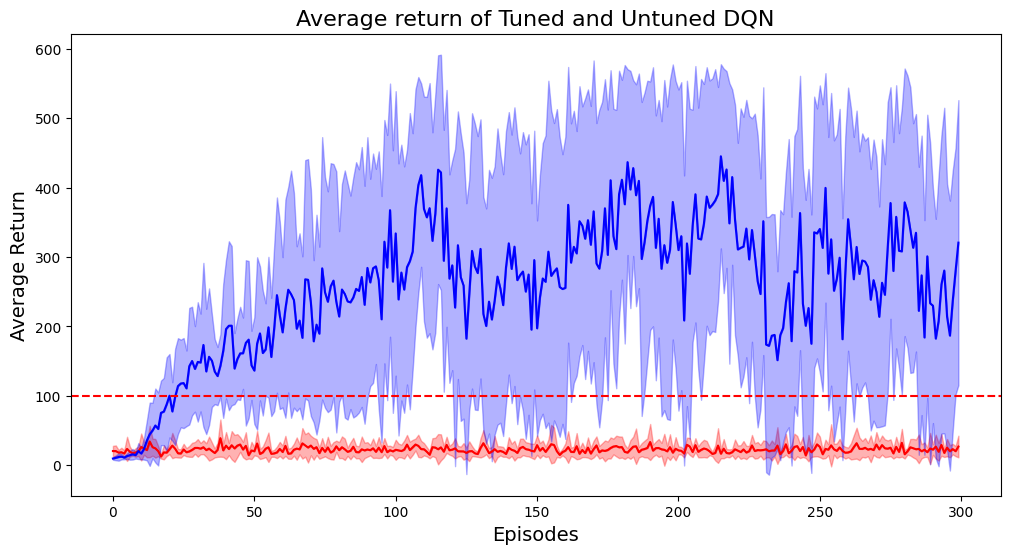

In [62]:
#  getting tuned data
# load model from pickle file
with open("tuned_DQN.pkl", 'rb') as file:  
    policy_net_tuned = pickle.load(file)
    
# to read out if needed
with open('tuned_DQN.json', 'r') as fp:
    tuned_data = json.load(fp) 

result_tuned = tuned_data["results_DQN_tuned"] 
result_tuned = torch.tensor(result_tuned)
means_tuned = result_tuned[0]
stds_tuned = result_tuned[1]


# getting untuned data
with open('untuned_model.json', 'r') as fp:
    untuned_data = json.load(fp)
    
result_untuned = untuned_data["run_result_untuned"]
result_untuned_mean_and_std = torch.tensor(result_untuned)
means_untuned = result_untuned_mean_and_std[0]
stds_untuned = result_untuned_mean_and_std[1]

# plotting tuned and untuned learning curves
plt.figure(figsize=(12,6))
plt.plot(torch.arange(300), means_untuned, color='r')
plt.fill_between(np.arange(300), means_untuned, means_untuned+stds_untuned, alpha=0.3, color='r')
plt.fill_between(np.arange(300), means_untuned, means_untuned-stds_untuned, alpha=0.3, color='r')

plt.plot(torch.arange(300), means_tuned, color='b')
plt.fill_between(np.arange(300), means_tuned, means_tuned+stds_tuned, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means_tuned, means_tuned-stds_tuned, alpha=0.3, color='b')
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Average Return", fontsize= 14)
plt.xlabel("Episodes", fontsize= 14)
plt.title("Average return of Tuned and Untuned DQN", fontsize= 16)

plt.show()

### Getting plot with and without $\epsilon$ decay 

#### training tuned DQN with no decay

In [ ]:
tuned_without_decay_dict={}

In [ ]:
runs_results_no_decay = train_model(lr = 0.01, 
                           epsilon = 0.9,
                           epsilon_percentage = 1.0,  # setting as no decay 
                           network_architecture = [4, 128, 128, 2],
                           optimizer_type = "Adam",
                           activation_func = "relu",
                           batch_size = 20,
                           replay_buffer_size = 10000,
                           update_target_num = 1)

result_testing_no_decay_mean_and_std = []
final_results = torch.tensor(runs_results_no_decay)
means = final_results.float().mean(0)
stds = final_results.float().std(0)
result_testing_no_decay_mean_and_std.append(means.tolist())
result_testing_no_decay_mean_and_std.append(stds.tolist())

tuned_without_decay_dict["testing_no_decay"] = result_testing_no_decay_mean_and_std

with open('tuned_DQN_no_decay.json', 'w') as fp:
    json.dump(tuned_without_decay_dict, fp) 


#### getting data for tuned DQN with decay and tuned DQN without decay and plotting

In [ ]:
# read out data without decay
with open('tuned_DQN_no_decay.json', 'r') as fp:
    data = json.load(fp) 
    
final_results_no_decay = data["testing_no_decay"] 
final_results_no_decay = torch.tensor(final_results_no_decay)
means_no_decay = final_results_no_decay[0]
stds_no_decay = final_results_no_decay[1]

# read out data with decay
with open('tuned_DQN.json', 'r') as fp:
    tuned_data = json.load(fp) 

result_tuned = tuned_data["result_tuned"] 
result_tuned = torch.tensor(result_tuned)
means_decay = result_tuned[0]
stds_decay = result_tuned[1]


plt.figure(figsize=(12,6))
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.plot(torch.arange(300), means_decay, color='b')
plt.fill_between(np.arange(300), means_decay, means_decay+stds_decay, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means_decay, means_decay-stds_decay, alpha=0.3, color='b')

plt.plot(torch.arange(300), means_no_decay, color='r')
plt.fill_between(np.arange(300), means_no_decay, means_no_decay+stds_no_decay, alpha=0.3, color='r')
plt.fill_between(np.arange(300), means_no_decay, means_no_decay-stds_no_decay, alpha=0.3, color='r')

plt.ylabel("Average Return", fontsize= 14)
plt.xlabel("Episodes", fontsize= 14)
plt.title("Average return of tuned DQN with and without ε decay", fontsize= 16)

plt.show()

old part


In [72]:
result_untuned_dict = {}

In [73]:
runs_results_untuned = train_model(lr = 1., 
                           epsilon = 1.,
                           epsilon_percentage = 1.,
                           network_architecture = [4, 2],
                           optimizer_type = "SGD",
                           activation_func = "relu",
                           batch_size = 1,
                           replay_buffer_size = 1,
                           update_target_num = 1)

result_untuned = []
final_results = torch.tensor(runs_results_untuned)
means = final_results.float().mean(0)
stds = final_results.float().std(0)
result_untuned.append(means.tolist())
result_untuned.append(stds.tolist())

result_untuned_dict["run_result_untuned"] = result_untuned

with open('untuned_model.json', 'w') as fp:
    json.dump(result_untuned_dict, fp) 

with open('untuned_model.json', 'r') as fp:
    data = json.load(fp)
    
result_untuned = data["run_result_untuned"]


Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

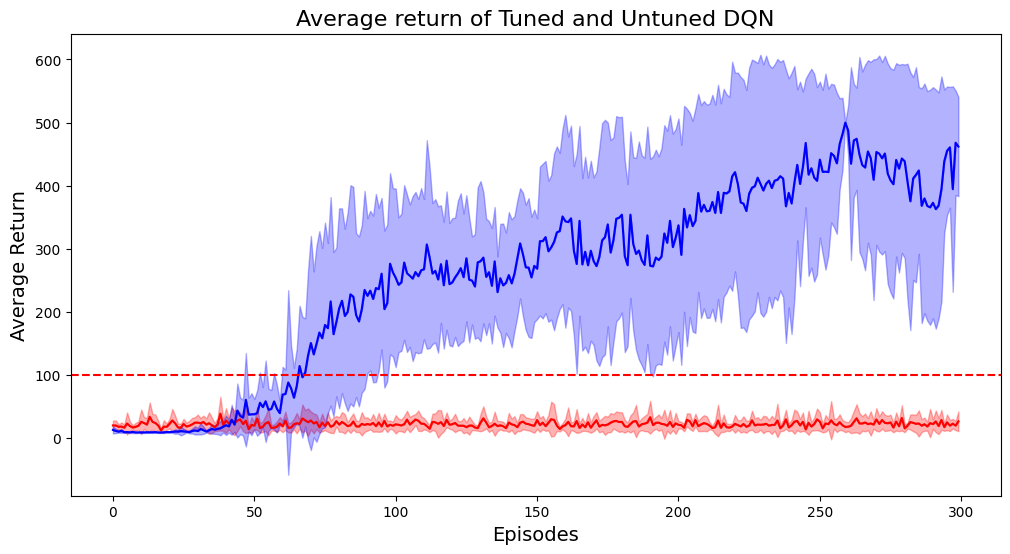

In [30]:
# plotting tuned and untuned learning curves
with open('untuned_model.json', 'r') as fp:
    untuned_data = json.load(fp)
    
result_untuned = untuned_data["run_result_untuned"]
result_untuned_mean_and_std = torch.tensor(result_untuned)
means_untuned = result_untuned_mean_and_std[0]
stds_untuned = result_untuned_mean_and_std[1]

with open('tuned_DQN_Adam.json', 'r') as fp:
    tuned_data = json.load(fp)
    
result_tuned = tuned_data["results_DQN_tuned"]    
result_tuned_mean_and_std = torch.tensor(result_tuned)
means_tuned = result_tuned_mean_and_std[0]
stds_tuned = result_tuned_mean_and_std[1]

plt.figure(figsize=(12,6))
plt.plot(torch.arange(300), means_untuned, color='r')
plt.fill_between(np.arange(300), means_untuned, means_untuned+stds_untuned, alpha=0.3, color='r')
plt.fill_between(np.arange(300), means_untuned, means_untuned-stds_untuned, alpha=0.3, color='r')

plt.plot(torch.arange(300), means_tuned, color='b')
plt.fill_between(np.arange(300), means_tuned, means_tuned+stds_tuned, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means_tuned, means_tuned-stds_tuned, alpha=0.3, color='b')
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Average Return", fontsize= 14)
plt.xlabel("Episodes", fontsize= 14)
plt.title("Average return of Tuned and Untuned DQN", fontsize= 16)

plt.show()

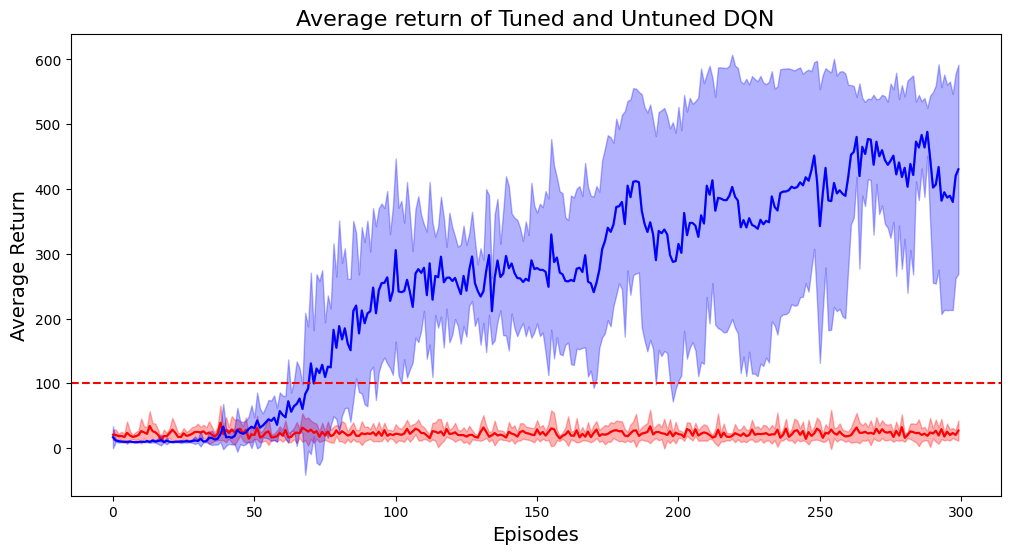

In [23]:
# plotting tuned and untuned learning curves
with open('untuned_model.json', 'r') as fp:
    untuned_data = json.load(fp)
    
result_untuned = untuned_data["run_result_untuned"]
result_untuned_mean_and_std = torch.tensor(result_untuned)
means_untuned = result_untuned_mean_and_std[0]
stds_untuned = result_untuned_mean_and_std[1]

with open('tuned_DQN.json', 'r') as fp:
    tuned_data = json.load(fp)
    
result_tuned = tuned_data["results_DQN_tuned"]    
result_tuned_mean_and_std = torch.tensor(result_tuned)
means_tuned = result_tuned_mean_and_std[0]
stds_tuned = result_tuned_mean_and_std[1]

plt.figure(figsize=(12,6))
plt.plot(torch.arange(300), means_untuned, color='r')
plt.fill_between(np.arange(300), means_untuned, means_untuned+stds_untuned, alpha=0.3, color='r')
plt.fill_between(np.arange(300), means_untuned, means_untuned-stds_untuned, alpha=0.3, color='r')

plt.plot(torch.arange(300), means_tuned, color='b')
plt.fill_between(np.arange(300), means_tuned, means_tuned+stds_tuned, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means_tuned, means_tuned-stds_tuned, alpha=0.3, color='b')
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Average Return", fontsize= 14)
plt.xlabel("Episodes", fontsize= 14)
plt.title("Average return of Tuned and Untuned DQN", fontsize= 16)

plt.show()

## Question 2

In [16]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

def visualise_DQN(DQN_policy_net, velocity, q=False):
    policy_net = DQN_policy_net   # randomly initialised, replace with your trained DQN

    angle_range = (.2095)*1.5 # you may modify this range
    omega_range = 2     # you may modify this range

    angle_samples = 100
    omega_samples = 100
    angles = torch.linspace(angle_range, -angle_range, angle_samples)
    omegas = torch.linspace(-omega_range, omega_range, omega_samples)

    plt.figure(figsize=(5,3))
        
    greedy_q_array = torch.zeros((angle_samples, omega_samples))
    policy_array = torch.zeros((angle_samples, omega_samples))
    for i, angle in enumerate(angles):
        for j, omega in enumerate(omegas):
            state = torch.tensor([0., velocity, angle, omega])
            with torch.no_grad():
                q_vals = policy_net(state)
                greedy_action = q_vals.argmax()
                greedy_q_array[i, j] = q_vals[greedy_action]
                policy_array[i, j] = greedy_action
    if q:
        plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
        plt.colorbar()
        plt.title(f"Q function for velocity={velocity}")
    else:
        contour_plot = plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
        # plt.clabel(contour_plot, inline=1, fontsize=10)
        labels = ["0 - move cart to left", "1 - move cart to right"]
        contour_labels = [contour_plot.collections[0],contour_plot.collections[1]]
        colours = ["#002f6d", "#edd54a"]
        contour_colours = [plt.Rectangle((0,0),1,1,fc=pc) for pc in colours]
        # for l in range(len(labels)):
        #     contour_plot.collections[l].set_label(labels[l])
        # print(policy_array)
        plt.legend(contour_colours, labels)
        plt.title(f"Greedy policy action for velocity={velocity}")
    plt.xlabel("Angle")
    plt.ylabel("Angular velocity")
    plt.show()

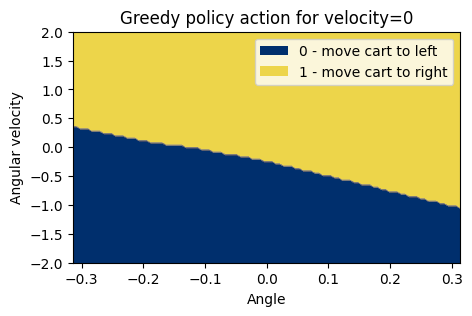

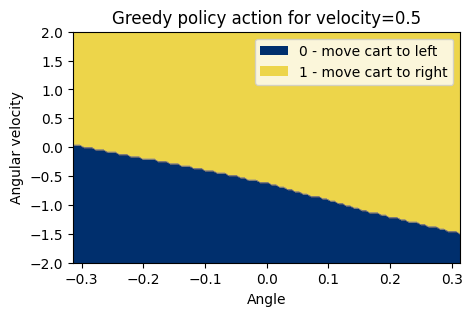

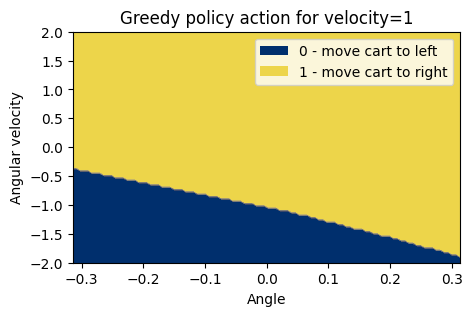

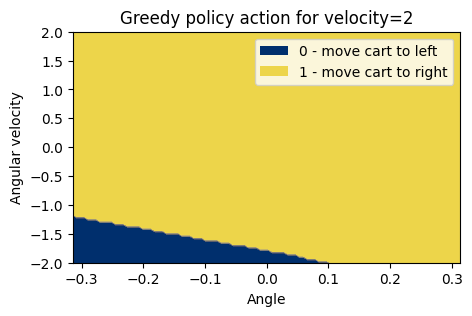

In [27]:
# load model from pickle file
# with open("tuned_DQN.pkl", 'rb') as file:  
#     policy_net_tuned = pickle.load(file)

cart_velocity = [0, 0.5, 1, 2]    
visualise_DQN(policy_net_tuned, velocity=cart_velocity[0], q=False)

visualise_DQN(policy_net_tuned, velocity=cart_velocity[1], q=False)
  
visualise_DQN(policy_net_tuned, velocity=cart_velocity[2], q=False)

visualise_DQN(policy_net_tuned, velocity=cart_velocity[3], q=False)

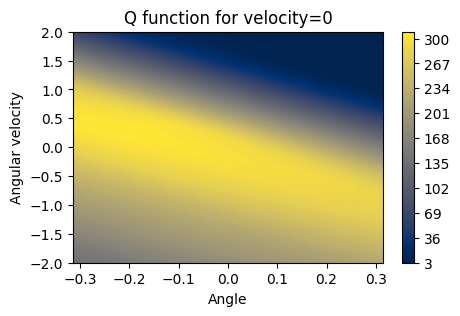

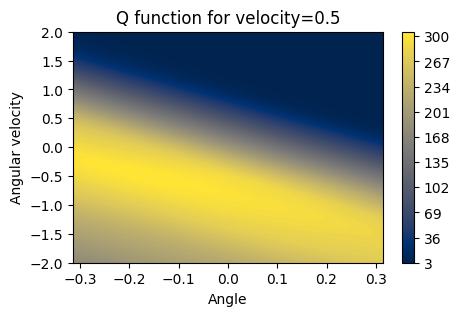

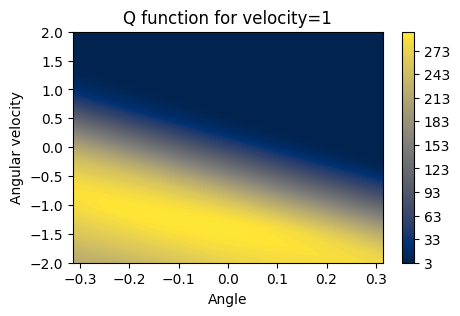

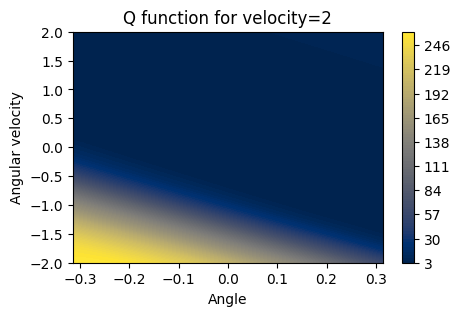

In [29]:
# load model from pickle file
# with open("tuned_DQN.pkl", 'rb') as file:  
#     policy_net_tuned = pickle.load(file)

cart_velocity = [0, 0.5, 1, 2]    
visualise_DQN(policy_net_tuned, velocity=cart_velocity[0], q=True)

visualise_DQN(policy_net_tuned, velocity=cart_velocity[1], q=True)
  
visualise_DQN(policy_net_tuned, velocity=cart_velocity[2], q=True)

visualise_DQN(policy_net_tuned, velocity=cart_velocity[3], q=True)

## other

### original code


In [16]:
runs_results = []

env = gym.make('CartPole-v1')
for run in range(NUM_RUNS):
    print(f"Starting run {run+1} of {NUM_RUNS}")
    policy_net = DQN([4,2])
    target_net = DQN([4,2])
    update_target(target_net, policy_net)
    target_net.eval()

    optimizer = optim.SGD(policy_net.parameters(), lr=1.)
    memory = ReplayBuffer(1)

    steps_done = 0

    episode_durations = []

    for i_episode in range(300):
        if (i_episode+1) % 50 == 0:
            print("episode ", i_episode+1, "/", 300)

        observation, info = env.reset()
        state = torch.tensor(observation).float()

        done = False
        terminated = False
        t = 0
        while not (done or terminated):

            # Select and perform an action
            action = epsilon_greedy(EPSILON, policy_net, state)

            observation, reward, done, terminated, info = env.step(action)
            reward = torch.tensor([reward])
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()

            memory.push([state, action, next_state, reward, torch.tensor([done])])

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if not len(memory.buffer) < 1:
                transitions = memory.sample(1)
                state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                # Compute loss
                mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                # Optimize the model
                optimizer.zero_grad()
                mse_loss.backward()
                optimizer.step()

            if done or terminated:
                episode_durations.append(t + 1)
            t += 1
        # Update the target network, copying all weights and biases in DQN
        if i_episode % 1 == 0:
            update_target(target_net, policy_net)
    runs_results.append(episode_durations)
print('Complete')

Starting run 1 of 10


TypeError: __init__() missing 1 required positional argument: 'activ_func'

In [ ]:
print(runs_results)

[[16, 25, 31, 18, 16, 21, 17, 11, 18, 19, 55, 25, 17, 10, 16, 33, 42, 24, 12, 13, 26, 22, 19, 10, 24, 30, 16, 11, 68, 13, 20, 20, 25, 30, 47, 21, 21, 40, 15, 20, 17, 14, 17, 23, 17, 14, 10, 12, 9, 22, 11, 38, 15, 22, 43, 43, 21, 16, 12, 11, 14, 20, 12, 18, 18, 20, 15, 12, 21, 36, 13, 32, 15, 29, 19, 26, 18, 12, 34, 15, 14, 30, 9, 22, 22, 9, 27, 12, 12, 14, 45, 11, 15, 22, 33, 12, 24, 12, 25, 49, 32, 11, 32, 32, 8, 22, 23, 16, 22, 27, 34, 12, 34, 40, 12, 22, 20, 23, 26, 14, 36, 14, 19, 27, 19, 18, 27, 12, 45, 19, 24, 21, 81, 19, 13, 14, 16, 12, 14, 29, 15, 26, 13, 17, 17, 16, 21, 22, 30, 10, 15, 30, 12, 15, 15, 54, 14, 18, 13, 48, 9, 11, 24, 12, 43, 9, 22, 50, 28, 19, 16, 34, 26, 19, 24, 38, 9, 11, 25, 30, 19, 14, 26, 22, 35, 12, 28, 13, 27, 38, 20, 19, 45, 26, 29, 14, 33, 23, 12, 15, 18, 21, 14, 17, 10, 19, 41, 61, 10, 23, 33, 20, 20, 15, 19, 16, 26, 24, 13, 26, 27, 15, 13, 30, 13, 15, 25, 15, 15, 11, 19, 10, 29, 24, 19, 12, 15, 11, 23, 27, 12, 13, 27, 50, 16, 10, 22, 11, 31, 43, 23, 1

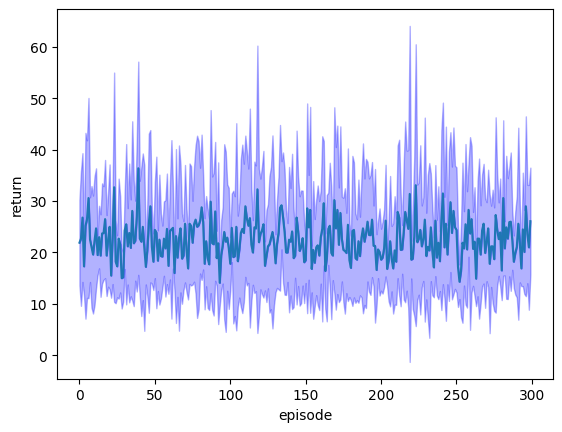

In [ ]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it

results = torch.tensor(runs_results)
means = results.float().mean(0)
stds = results.float().std(0)

plt.plot(torch.arange(300), means)
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.show()

### original visualising Question 2


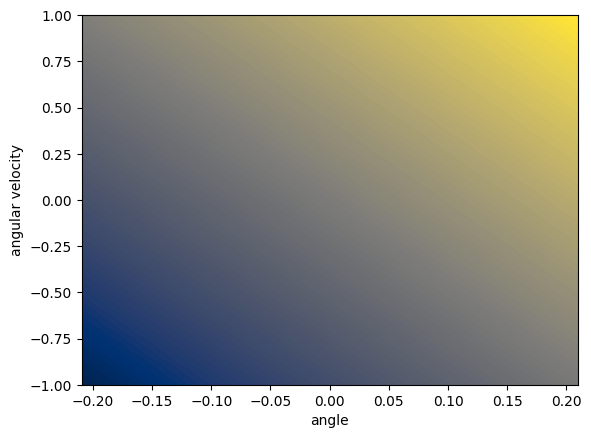

In [ ]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can modify these plots

# Make sure to include appropriate labels and/or legends when presenting your plot

policy_net = DQN([4,2])   # randomly initialised, replace with your trained DQN
q = True    # whether q values or greedy policy is visualised

angle_range = .2095 # you may modify this range
omega_range = 1     # you may modify this range

angle_samples = 100
omega_samples = 100
angles = torch.linspace(angle_range, -angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)

greedy_q_array = torch.zeros((angle_samples, omega_samples))
policy_array = torch.zeros((angle_samples, omega_samples))
for i, angle in enumerate(angles):
    for j, omega in enumerate(omegas):
        state = torch.tensor([0., 0., angle, omega])
        with torch.no_grad():
            q_vals = policy_net(state)
            greedy_action = q_vals.argmax()
            greedy_q_array[i, j] = q_vals[greedy_action]
            policy_array[i, j] = greedy_action
if q:
    plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
else:
    plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
plt.xlabel("angle")
plt.ylabel("angular velocity")
plt.show()